In [72]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

In [3]:
train_df = pd.read_csv('train.csv') 
test_df = pd.read_csv('test.csv')

In [4]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [20]:
def RMSLE(y_true, y_pred):
    y_pred_use = y_pred.clip(0)
    rmsle = mean_squared_log_error(y_true, y_pred_use)**(1/2)
    return rmsle

In [21]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    acc_df = pd.DataFrame(data = {"RMSE": [mean_squared_error(y_true, y_pred)**(1/2)],
                                  "MAE": [mean_absolute_error(y_true, y_pred)],
                                  "R^2": [r2_score(y_true, y_pred)],
                                  "RMSLE": [RMSLE(y_true, y_pred)]})
    display(acc_df.style.hide_index())

In [5]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['hour'] = train_df['datetime'].dt.hour
train_df['DOW'] = train_df['datetime'].dt.dayofweek

test_df['year'] = test_df['datetime'].dt.year
test_df['month'] = test_df['datetime'].dt.month
test_df['hour'] = test_df['datetime'].dt.hour
test_df['DOW'] = test_df['datetime'].dt.dayofweek


In [11]:
## Split dataset into casual vs. registered voters? Take out correlated variables? CHANGE
train_df.head()
#train_df.corr()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,DOW
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


In [41]:
## Kitchen sink variables CHANGE

ind_variables_selected = ["season", "holiday", "weather", 'workingday', 'temp', "atemp", "humidity", "windspeed",  'year', 'month', 'hour', 'DOW']



In [111]:
## Create matrices CHANGE

X_orig_train = train_df[ind_variables_selected]
Y_orig_train = train_df['count'] # CHANGE
X_test = test_df[ind_variables_selected]
X_train, X_valid, Y_train, Y_valid = train_test_split(X_orig_train, Y_orig_train, test_size = 0.25, random_state = 201)

In [56]:
## Boosted model for combined count

xgb_model = XGBRegressor(max_depth=6,
                         n_estimators = 50,
                         learning_rate=.1,
                         ccp_alpha=10,
                         random_state=201)
xgb_model.fit(X_train, Y_train)
xgb_pred = xgb_model.predict(X_valid)
#len(xgb_pred)


[20:44:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:576: 
Parameters: { "ccp_alpha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [57]:
## Get importance

pd.DataFrame({'Importance': xgb_model.feature_importances_}, index=ind_variables_selected).sort_values(['Importance'], ascending=False)

,Importance
hour,0.249316
workingday,0.201787
year,0.141236
atemp,0.114751
season,0.079467
temp,0.064264
month,0.040467
DOW,0.036832
weather,0.030332
humidity,0.029171


In [65]:
accuracy(Y_valid, xgb_pred)
import warnings
warnings.filterwarnings('ignore')

RMSE,MAE,R^2,RMSLE
46.051822,28.799728,0.934764,0.411702


In [94]:
## Grid search for optimal
%time
#parameters = {'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 50],
#              'n_estimators': [5, 10, 100, 500, 1000, 2000, 3000, 5000],
#              'learning_rate': [0.001, 0.002, 0.005, 0.007, 0.01, 0.1]}


parameters = {'max_depth': [1, 3, 6, 8, 9],
              'n_estimators': [5, 200, 500],
              'learning_rate': [0.001, 0.01]}

gs_rt_model = GridSearchCV(XGBRegressor(max_depth = 1, n_estimators=5, random_state=201, learning_rate=0.001), param_grid=parameters, cv=4, n_jobs=num_cpus, scoring=make_scorer(RMSLE, greater_is_better=False))
gs_rt_model.fit(X_train, Y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.001, max_delta_step=None,
                                    max_depth=1, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_e...s=5, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=201, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                 

In [107]:
gs_rt_model.best_params_
results=pd.DataFrame(gs_rt_model.cv_results_)
results.head()
#gs_rt_model.best_score_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009464,0.001774,0.002589,0.000154,0.001,1,5,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",-3.922989,-3.896575,-3.937653,-3.955375,-3.928148,0.021536,28
1,0.265216,0.025686,0.003711,0.000094,0.001,1,200,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",-1.579859,-1.577790,-1.592977,-1.572607,-1.580808,0.007506,19
2,0.570887,0.023225,0.004485,0.000085,0.001,1,500,"{'learning_rate': 0.001, 'max_depth': 1, 'n_es...",-1.080907,-1.092270,-1.086188,-1.057323,-1.079172,0.013240,15
3,0.039791,0.028092,0.002559,0.000069,0.001,3,5,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es...",-3.925141,-3.889506,-3.938501,-3.946040,-3.924797,0.021706,26
4,0.502856,0.002607,0.004513,0.000061,0.001,3,200,"{'learning_rate': 0.001, 'max_depth': 3, 'n_es...",-1.545201,-1.529968,-1.553793,-1.521675,-1.537659,0.012568,16


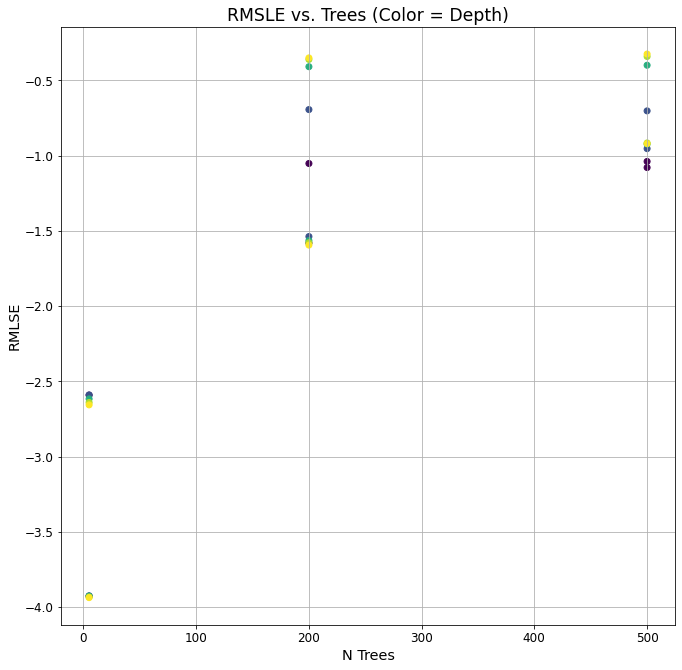

In [134]:
fig, ax = plt.subplots()
ax.scatter(results.param_n_estimators, results.mean_test_score, c=results.param_max_depth)

ax.set(xlabel='N Trees', ylabel='RMLSE',
       title='RMSLE vs. Trees (Color = Depth)')
ax.grid()
plt.show()


In [135]:
gs_rt_model.best_params_

{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 500}

In [136]:
## Retrain using best parameters

rt_model_retrain = XGBRegressor(random_state=201,ccp_alpha=10, **gs_rt_model.best_params_) # Remove CCP?
rt_model_retrain.fit(X_orig_train, Y_orig_train)

[23:34:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1634712354882/work/src/learner.cc:576: 
Parameters: { "ccp_alpha" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', ccp_alpha=10,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=201,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [140]:
## Test retrained model

xgb_pred = rt_model_retrain.predict(X_valid)
accuracy(Y_valid, xgb_pred)

RMSE,MAE,R^2,RMSLE
21.943863,13.821832,0.985188,0.194659


In [190]:
## Create predictions for test set

final_pred = rt_model_retrain.predict(X_test)

In [191]:
## Create submission

sample_submission = pd.read_csv('sampleSubmission.csv')
sample_submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [192]:
## Remove negative values

sample_submission['count'] = final_pred
sample_submission["count"][(sample_submission["count"] <= 0)]=0
sample_submission[(sample_submission["count"] <= 0)]
#sample_submission.sort_values(by="count",ascending=True)
#sample_submission[(sample_submission["count"] <= 0)]

,datetime,count
216,2011-01-30 07:00:00,0.0
823,2011-04-23 07:00:00,0.0
3206,2011-12-31 07:00:00,0.0


In [193]:
sample_submission.to_csv('finalSubmission.csv', index=False)